# **Proyecto predicción de ventas en el tiempo**

Se importan las librerias necesarias

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import re
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


import math


Librerías de modelos

In [109]:
import statsmodels.tsa.api as smt
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings


Se importan los datos de la tabla relacionada con las ventas en el tiempo que serán los datos utilizados para el entrenamiento del modelo

In [129]:
path_ventas = "D:/Github/Proyecto-MLE/forecast-fastapi-docker/tickitdb/sales_tab.txt"
df_ventas = pd.read_csv(path_ventas, sep="\t", header=None,
                        names=["id_sales", "id_list", "selleric_id", "buyer_id", "event_id", "date_id", "num_tick_sold","price", "comission", "time" ])

Se observan los datos de las ventas para mirar si se necesita algún preprocesamiento

In [111]:
df_ventas.head()

,id_sales,id_list,selleric_id,buyer_id,event_id,date_id,num_tick_sold,price,comission,time
0,1,1,36861,21191,7872,1875,4,728,109.20,2/18/2008 02:36:48
1,2,4,8117,11498,4337,1983,2,76,11.40,6/6/2008 05:00:16
2,3,5,1616,17433,8647,1983,2,350,52.50,6/6/2008 08:26:17
3,4,5,1616,19715,8647,1986,1,175,26.25,6/9/2008 08:38:52
4,5,6,47402,14115,8240,2069,2,154,23.10,8/31/2008 09:17:02


In [112]:
df_ventas.duplicated().sum()  #Se puede observar que no hay duplicados

0

In [113]:
df_ventas.isnull().sum()  #Se puede observar que no hay registros nulos

id_sales         0
id_list          0
selleric_id      0
buyer_id         0
event_id         0
date_id          0
num_tick_sold    0
price            0
comission        0
time             0
dtype: int64

In [114]:
df_ventas.info() #Se puede observar que hay que realizar una modificación del tipo de dato de las fechas para trabajar con ellas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172456 entries, 0 to 172455
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_sales       172456 non-null  int64  
 1   id_list        172456 non-null  int64  
 2   selleric_id    172456 non-null  int64  
 3   buyer_id       172456 non-null  int64  
 4   event_id       172456 non-null  int64  
 5   date_id        172456 non-null  int64  
 6   num_tick_sold  172456 non-null  int64  
 7   price          172456 non-null  int64  
 8   comission      172456 non-null  float64
 9   time           172456 non-null  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 13.2+ MB


In [131]:
df_ventas['time'] = pd.to_datetime(df_ventas['time'])

In [124]:
df_ventas.describe()

,id_sales,id_list,selleric_id,buyer_id,event_id,date_id,num_tick_sold,price,comission
count,172456.000000,172456.000000,172456.000000,172456.000000,172456.000000,172456.000000,172456.000000,172456.000000,172456.000000
mean,86228.500000,101476.463225,25031.743076,16524.125876,4391.810294,2008.303683,2.002534,642.282269,96.342340
std,49783.903349,62763.741083,14432.144747,11780.904373,2544.103778,95.402125,1.068628,869.275106,130.391266
min,1.000000,1.000000,1.000000,1.000000,1.000000,1827.000000,1.000000,20.000000,3.000000
25%,43114.750000,48411.000000,12518.000000,6606.000000,2182.000000,1926.000000,1.000000,194.000000,29.100000
50%,86228.500000,98445.000000,25106.500000,14407.000000,4380.000000,2009.000000,2.000000,386.000000,57.900000
75%,129342.250000,148334.500000,37583.250000,24744.000000,6583.000000,2090.000000,2.000000,758.000000,113.700000
max,172456.000000,235494.000000,49990.000000,49984.000000,8798.000000,2191.000000,8.000000,12624.000000,1893.600000


El modelo solicitado solo quiere predecir las ventas 7 días despues por lo que se eliminarán las columnas con las que no se trabajarán

In [ ]:
df_ventas1 = df_ventas.set_index('time')

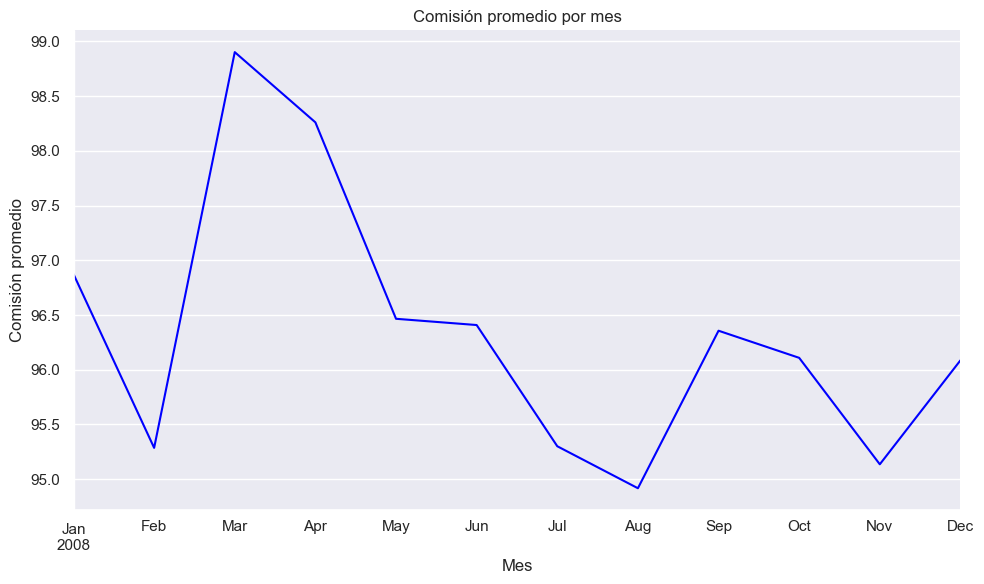

In [141]:
# agrupar por mes y calcular la comisión promedio
df_comision_mes = df_ventas1.groupby(pd.Grouper(freq='M'))['comission'].mean()

# plotear la gráfica
ax = df_comision_mes.plot(kind='line', color='blue', figsize=(10, 6))
ax.set_xlabel('Mes')
ax.set_ylabel('Comisión promedio')
ax.set_title('Comisión promedio por mes')
sns.despine()
plt.tight_layout()

A partir del anàlisis exploratorio se miuestra que el mayor promedio de comisiones por mes se tiene en marzo

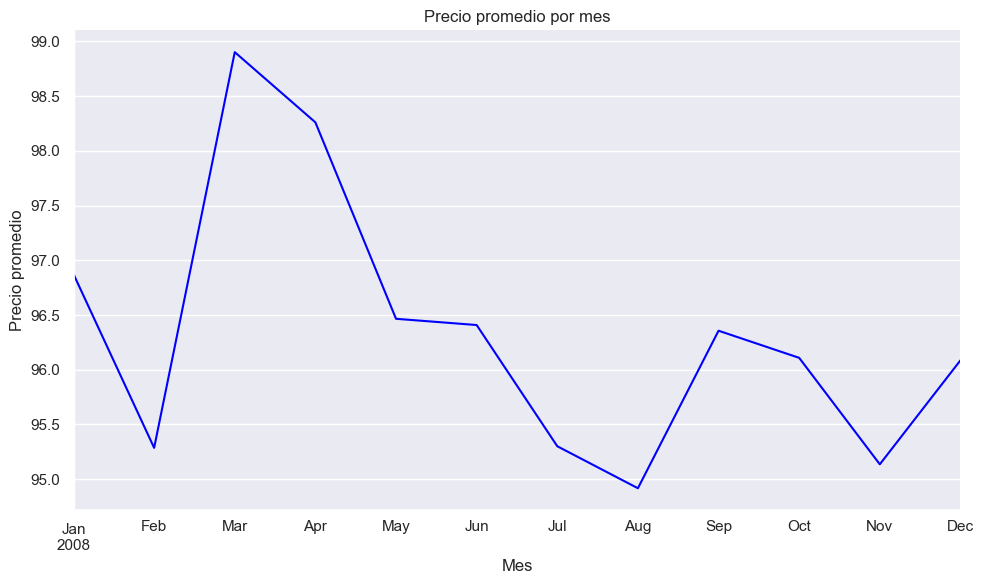

In [143]:
# agrupar por mes y calcular la comisión promedio
df_precio_mes = df_ventas1.groupby(pd.Grouper(freq='M'))['price'].mean()

# plotear la gráfica
ax = df_comision_mes.plot(kind='line', color='blue', figsize=(10, 6))
ax.set_xlabel('Mes')
ax.set_ylabel('Precio promedio')
ax.set_title('Precio promedio por mes')
sns.despine()
plt.tight_layout()

El resultado mostrado en la grafica visualizada establece que en marzo, es el mes donde se tiene mas ganancias y por ende mayores comisiones

In [97]:
df_sales = df_ventas[['id_sales', 'time']]

In [98]:
df_sales

,id_sales,time
0,1,2008-02-18 02:36:48
1,2,2008-06-06 05:00:16
2,3,2008-06-06 08:26:17
3,4,2008-06-09 08:38:52
4,5,2008-08-31 09:17:02
...,...,...
172451,172452,2008-10-22 02:27:22
172452,172453,2008-08-30 02:27:23
172453,172454,2008-10-10 02:27:24
172454,172455,2008-12-03 02:27:26


Se realizara un analisis exploratorio de algunos datos antes de borrar las columnas que no se emplearan

In [99]:
# Agrupar por fecha
ventas_por_fecha = df_sales.groupby(pd.Grouper(key='time', freq='D'))

# Contar el número de ventas en cada fecha
df_ventas_fecha = ventas_por_fecha.count()

In [117]:
df_ventas_fecha

,num_ventas
time,
2008-01-01,9
2008-01-02,30
2008-01-03,46
2008-01-04,82
2008-01-05,97
...,...
2008-12-27,83
2008-12-28,75
2008-12-29,63


In [118]:
df_ventas_fecha.rename(columns={'id_sales': 'num_ventas'}, inplace=True)

In [119]:
df_ventas_fecha

,num_ventas
time,
2008-01-01,9
2008-01-02,30
2008-01-03,46
2008-01-04,82
2008-01-05,97
...,...
2008-12-27,83
2008-12-28,75
2008-12-29,63


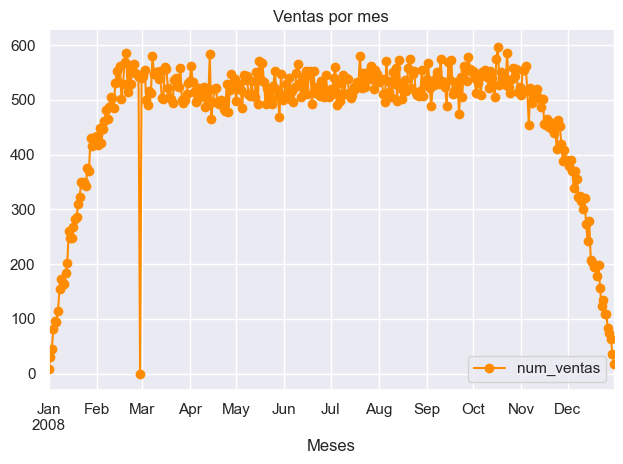

In [144]:


months = df_ventas_fecha['num_ventas'].plot(marker = 'o',color = 'darkorange', label="num_ventas")

months.set(xlabel = "Meses", title = "Ventas por mes")

sns.despine()
plt.tight_layout()


months.legend()

Se implementara el modelo ARIMA para hacer la prediccion de ventas del modelo despues de la ultima fecha durante 7 días posteriores

In [146]:
#Eliminando los outliers
df_model = df_ventas_fecha[np.abs(df_ventas_fecha['num_ventas'] - df_ventas_fecha['num_ventas'].mean()) <= (3 * df_ventas_fecha['num_ventas'].std())]

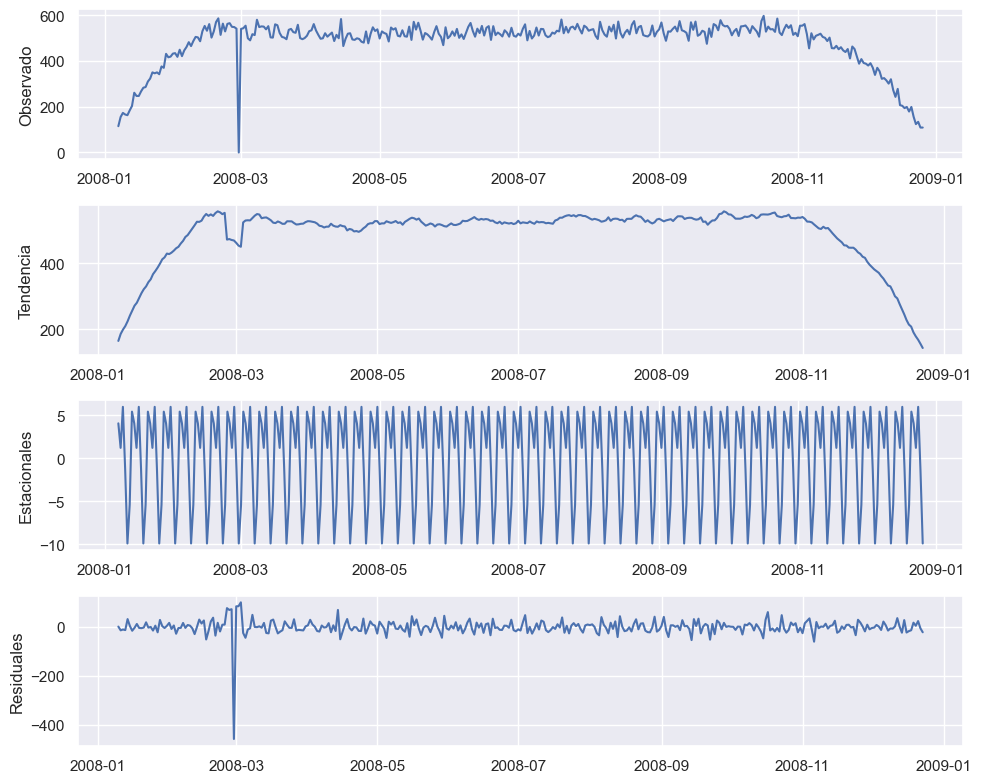

In [152]:
#Creando el dataset con frecuencia diaria
idx = pd.date_range(start=df_model.index.min(), end=df_model.index.max(), freq='D')


df_model = df_model.reindex(idx, fill_value=0)

#Descomposición de la serie de tiempo en sus componentes
decomp = sm.tsa.seasonal_decompose(df_model['num_ventas'], model='additive')


fig, axes = plt.subplots(4, 1, figsize=(10,8))
axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observado')
axes[1].plot(decomp.trend)
axes[1].set_ylabel('Tendencia')
axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Estacionales')
axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuales')
plt.tight_layout()
plt.show()

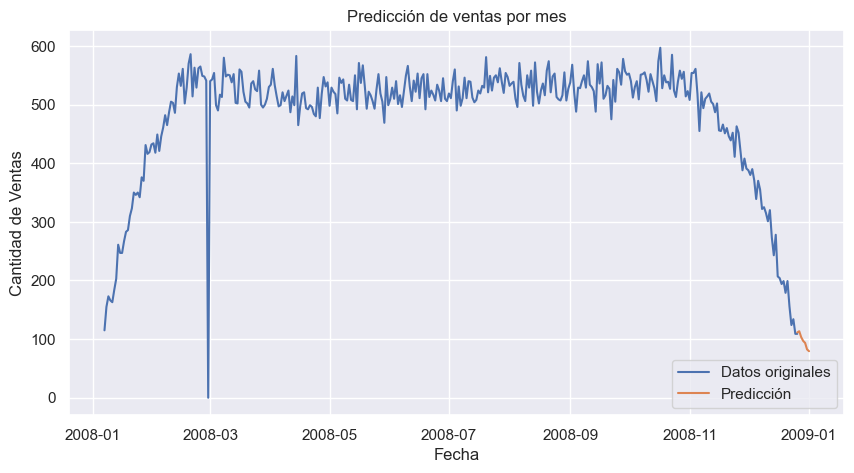

In [156]:
# Ajuste del modelo a todos los datos disponibles
model = sm.tsa.statespace.SARIMAX(df_model['num_ventas'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 7))
results = model.fit()

# Predicción de los próximos 7 días a partir de la última fecha disponible en el conjunto de datos original
last_date = df_model.index[-1]
idx = pd.date_range(start=last_date, periods=7, freq='D')
pred = results.forecast(steps=7)

# Gráfico de los resultados de la predicción
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_model.index, df_model['num_ventas'], label='Datos originales')
ax.plot(idx, pred, label='Predicción')
ax.set_title('Predicción de ventas por mes')
ax.set_xlabel('Fecha')
ax.set_ylabel('Cantidad de Ventas')
ax.legend()
plt.show()